## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   kernel_regularizer=l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   kernel_regularizer=l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 256]
MOMENTUM = 0.95
l2_ratio=[1e-4, 1e-8]
drop_ratio=[0.1, 0.2]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, L2_ratio in enumerate(l2_ratio):
    for i, Drop_ratio in enumerate(drop_ratio):
        for i, BATCH_size in enumerate(BATCH_SIZE):
            model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=L2_ratio, drp_ratio=Drop_ratio)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_size, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

            exp_name_tag = "exp-(%s,%s,%s)" % (str(L2_ratio),str(Drop_ratio),str(BATCH_size))
            results[exp_name_tag] = {'train-loss': train_loss,
                                    'valid-loss': valid_loss,
                                    'train-acc': train_acc,
                                    'valid-acc': valid_acc}

===========================] - 6s 28ms/step - loss: 1.1752 - accuracy: 0.5810 - val_loss: 1.3913 - val_accuracy: 0.5105
Epoch 38/50
196/196 [==============================] - 6s 29ms/step - loss: 1.1761 - accuracy: 0.5790 - val_loss: 1.4158 - val_accuracy: 0.5001
Epoch 39/50
196/196 [==============================] - 6s 29ms/step - loss: 1.1877 - accuracy: 0.5733 - val_loss: 1.3966 - val_accuracy: 0.5036
Epoch 40/50
196/196 [==============================] - 6s 30ms/step - loss: 1.1858 - accuracy: 0.5738 - val_loss: 1.4093 - val_accuracy: 0.5000
Epoch 41/50
196/196 [==============================] - 6s 30ms/step - loss: 1.1641 - accuracy: 0.5821 - val_loss: 1.3684 - val_accuracy: 0.5149
Epoch 42/50
196/196 [==============================] - 6s 28ms/step - loss: 1.1505 - accuracy: 0.5865 - val_loss: 1.3639 - val_accuracy: 0.5181
Epoch 43/50
196/196 [==============================] - 6s 29ms/step - loss: 1.1416 - accuracy: 0.5910 - val_loss: 1.3992 - val_accuracy: 0.5092
Epoch 44/50
196/

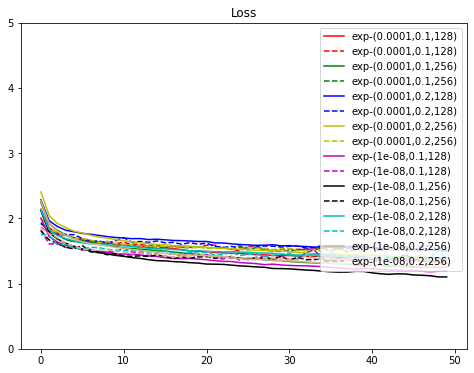

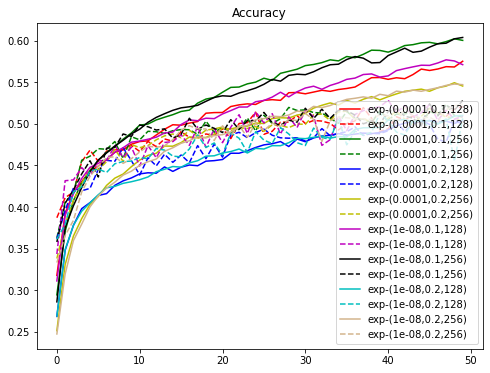

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c", "tan"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()